In [1]:
import os
import zipfile as zf
import cv2
import random
import glob

import numpy as np 
from numpy import array
from numpy import argmax
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, regularizers
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Layer
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping

from keras.preprocessing import image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

%matplotlib inline

C:\Users\DY\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
files = zf.ZipFile("trafficsigns_dataset.zip")
files.extractall() # extract the dataset files
files.close()

for dirname, _, filenames in os.walk('./trafficsigns_dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print(os.listdir('./trafficsigns_dataset'))

# ['.DS_Store', 'diamond', 'hex', 'Readme.txt', 'round', 'square', 'triangle']
# diamond - [rightofway]
# hex - [stop]
# round - [bicycle, limitedtraffic, noentry, noparking, roundabout, speed, trafficdirective, traveldirection]
# square -[continue, crossing, laneend, parking]
# triangle - [giveway, warning]

./trafficsigns_dataset\.DS_Store
./trafficsigns_dataset\Readme.txt
./trafficsigns_dataset\diamond\rightofway\00032_00000.png
./trafficsigns_dataset\diamond\rightofway\00032_00001.png
./trafficsigns_dataset\diamond\rightofway\00032_00002.png
./trafficsigns_dataset\diamond\rightofway\00037_00000.png
./trafficsigns_dataset\diamond\rightofway\00037_00001.png
./trafficsigns_dataset\diamond\rightofway\00037_00002.png
./trafficsigns_dataset\diamond\rightofway\00039_00000.png
./trafficsigns_dataset\diamond\rightofway\00039_00001.png
./trafficsigns_dataset\diamond\rightofway\00039_00002.png
./trafficsigns_dataset\diamond\rightofway\00042_00000.png
./trafficsigns_dataset\diamond\rightofway\00042_00001.png
./trafficsigns_dataset\diamond\rightofway\00042_00002.png
./trafficsigns_dataset\diamond\rightofway\00044_00000.png
./trafficsigns_dataset\diamond\rightofway\00044_00001.png
./trafficsigns_dataset\diamond\rightofway\00044_00002.png
./trafficsigns_dataset\diamond\rightofway\00045_00000.png
./tra

./trafficsigns_dataset\square\parking\00827_00000.png
./trafficsigns_dataset\square\parking\00827_00001.png
./trafficsigns_dataset\square\parking\00827_00002.png
./trafficsigns_dataset\square\parking\00828_00000.png
./trafficsigns_dataset\square\parking\00828_00001.png
./trafficsigns_dataset\square\parking\00828_00002.png
./trafficsigns_dataset\square\parking\00833_00000.png
./trafficsigns_dataset\square\parking\00833_00001.png
./trafficsigns_dataset\square\parking\00833_00002.png
./trafficsigns_dataset\square\parking\00850_00000.png
./trafficsigns_dataset\square\parking\00850_00001.png
./trafficsigns_dataset\square\parking\00850_00002.png
./trafficsigns_dataset\square\parking\00851_00000.png
./trafficsigns_dataset\square\parking\00995_00000.png
./trafficsigns_dataset\square\parking\00995_00001.png
./trafficsigns_dataset\square\parking\01021_00000.png
./trafficsigns_dataset\square\parking\01021_00001.png
./trafficsigns_dataset\square\parking\01021_00002.png
./trafficsigns_dataset\squar

In [3]:
os.remove('./trafficsigns_dataset/.DS_Store') 
os.remove('./trafficsigns_dataset/Readme.txt')

#### Prepare Dataset for Signs and Shape

In [4]:
image_list = [] # list to store filepath, target labels
for filepath in glob.glob('./trafficsigns_dataset/**/*.png', recursive=True): 
    filename = filepath.split("/")[-1]
    labels = filepath.split("\\")[-2] # extract the target from the filenames
    image_list.append((filepath, labels)) # append filepath and target labels to the image_list 
    
data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])
d = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5, 
     'roundabout':6, 'speed':7, 'trafficdirective':8, 'traveldirection': 9, 'continue':10, 'crossing':11, 
     'laneend':12, 'parking':13, 'giveway':14, 'warning':15}

data['labels_num'] = data['label'].map(d, na_action='ignore')
data = data.loc[:,'image_path':'labels_num']

train_data, test_data = train_test_split(data, test_size=0.2, random_state=2) # split trainset to have 20% test data, 20% validation data and 60% train data
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=2)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0])) # check shape of the splits

Train data : 2219, Val Data: 740, Test Data: 740


In [5]:
data

,image_path,label,labels_num
0,./trafficsigns_dataset\diamond\rightofway\0003...,rightofway,0
1,./trafficsigns_dataset\diamond\rightofway\0003...,rightofway,0
2,./trafficsigns_dataset\diamond\rightofway\0003...,rightofway,0
3,./trafficsigns_dataset\diamond\rightofway\0003...,rightofway,0
4,./trafficsigns_dataset\diamond\rightofway\0003...,rightofway,0
...,...,...,...
3694,./trafficsigns_dataset\triangle\warning\01947_...,warning,15
3695,./trafficsigns_dataset\triangle\warning\01947_...,warning,15
3696,./trafficsigns_dataset\triangle\warning\01971_...,warning,15
3697,./trafficsigns_dataset\triangle\warning\01971_...,warning,15


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last') # generator follows format of our images
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data, # take data from the train dataframe
        directory='./',
        x_col="image_path", 
        #shuffle=False, 
        y_col="label",
        target_size=(28, 28), # we want our image size to be 28 by 28
        batch_size=batch_size, # load in batch size 
        class_mode='categorical') # labels are multiclass categorical

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        shuffle=False,
        y_col="label",
        target_size=(28, 28),
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [7]:
image_list = []
for filepath in glob.glob('./trafficsigns_dataset/**/*.png', recursive=True): 
    filename = filepath.split("/")[-1]
    labels = filepath.split("\\")[-3]
    image_list.append((filepath, labels))
    
data_shape = pd.DataFrame(data=image_list, columns=['image_path', 'label'])
d = {'diamond':0, 'hex':1,'round':2,'square':3,'triangle':4}

data_shape['labels_num'] = data_shape['label'].map(d, na_action='ignore')
data_shape = data_shape.loc[:,'image_path':'labels_num']

train_data_shape, test_data_shape = train_test_split(data_shape, test_size=0.2, random_state=2)
train_data_shape, val_data_shape = train_test_split(train_data_shape, test_size=0.25, random_state=2)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_shape.shape[0], val_data_shape.shape[0], test_data_shape.shape[0]))

Train data : 2219, Val Data: 740, Test Data: 740


In [8]:
data_shape

,image_path,label,labels_num
0,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0
1,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0
2,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0
3,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0
4,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0
...,...,...,...
3694,./trafficsigns_dataset\triangle\warning\01947_...,triangle,4
3695,./trafficsigns_dataset\triangle\warning\01947_...,triangle,4
3696,./trafficsigns_dataset\triangle\warning\01971_...,triangle,4
3697,./trafficsigns_dataset\triangle\warning\01971_...,triangle,4


In [9]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator_shape = train_datagen.flow_from_dataframe(
        dataframe=train_data_shape,
        directory='./',
        x_col="image_path",
        #shuffle=False,
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_shape = val_datagen.flow_from_dataframe(
        dataframe=val_data_shape,
        directory='./',
        x_col="image_path",
        shuffle=False,
        y_col="label",
        target_size=(28, 28),
        class_mode='categorical')

Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


#### EDA (Image Exploration)

(array([172.,  27., 171.,  76., 225., 154.,  55., 198., 112.,  66., 118.,
         56.,  65., 171., 139., 414.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <BarContainer object of 16 artists>)

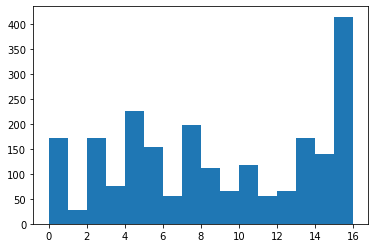

In [10]:
target = train_data['labels_num']

plt.hist(target, bins = np.arange(17))

(array([ 172.,   27., 1057.,  410.,  553.]),
 array([0, 1, 2, 3, 4, 5]),
 <BarContainer object of 5 artists>)

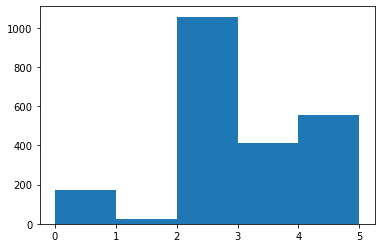

In [11]:
target = train_data_shape['labels_num']

plt.hist(target, bins = np.arange(6))

We note that there is class imbalance here.

(32, 28, 28, 3)
(28, 28, 3)


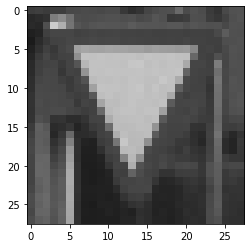

In [12]:
batch=next(train_generator)  # returns the next batch of images and labels 
print(batch[0].shape) # batch[0] is the images, batch[1] are the labels
img=batch[0][0]   # this is the first image  batch[0][1] would be the next image
print (img.shape)
plt.imshow(img)   # shows the first image

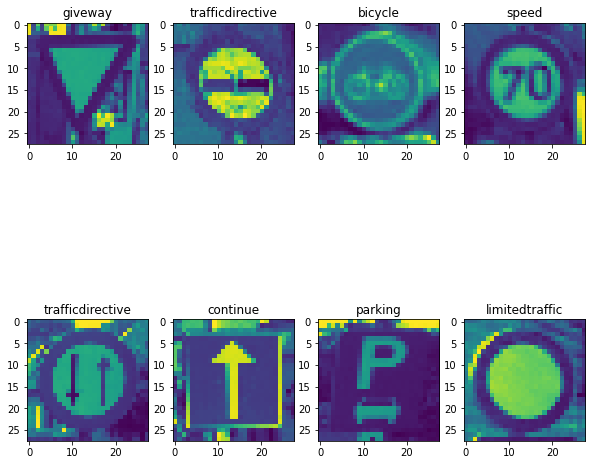

In [13]:
label_names = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5, 
     'roundabout':6, 'speed':7, 'trafficdirective':8, 'traveldirection': 9, 'continue':10, 'crossing':11, 
     'laneend':12, 'parking':13, 'giveway':14, 'warning':15}
d_inv = {v:k for k, v in label_names.items()}

img_list = list(train_data['image_path'])
target_list = list(train_data['labels_num'])

fig = plt.figure(figsize = [10,10])

for i in np.arange(8): # plots out some images extracted from the train dataset
    plt.subplot(2,4,i+1) # plots dim 2 column by 4 rows
    img = Image.open(img_list[i]) # open images by index
    plt.imshow(img)
    plt.title(d_inv[target_list[i]]) # label images by target

In [15]:
im = cv2.imread(r'./trafficsigns_dataset/diamond/rightofway/00032_00000.png') # read a random image 
h, w, c = im.shape # check the dimensions of image 
print('width:  ', w)
print('height: ', h)
print('channel:', c)
print('data type:', type(im))

width:   28
height:  28
channel: 3
data type: <class 'numpy.ndarray'>


#### Functions for below tabulated here

In [16]:
def plot_accuracy_loss(model, history): # plot f1 score and the cateogrical cross entropy loss during the training phase by model and history objext which fits the model
    
    fig = plt.figure(figsize=(10,10))

    # Plot F1 Score
    plt.subplot(211)
    plt.plot(history.history['f1_score'],'b--', label = "training") # plot train line to be blue
    plt.plot(history.history['val_f1_score'], 'r--', label = "validation") # plot val line to be red
    plt.title("Training F1 Vs Validation F1")
    plt.ylabel("F1 Score")
    plt.legend()

    # Plot loss function
    plt.subplot(212)
    plt.plot(history.history['loss'],'b--', label = "training")
    plt.plot(history.history['val_loss'], 'r--', label = "validation")
    plt.title("Training Loss Vs Validation Loss")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.show()

In [17]:
def display_rand_img(class_names, images, labels):  # display a random image from 'images' and its correspond label from 'label'
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + str(class_names[labels[index]]))
    plt.show()

## Models for Traffic Sign Shapes

### Algorithm 1: Neural Networks

#### Model 1 - NN (Using Keras)

In [18]:
OUTPUT_CLASSES = 16 # there are 16 classes for 'rightofway', 'stop', 'bicycle', 'limitedtraffic', 'noentry', 'noparking', 'roundabout', 'speed', 'trafficdirective', 'traveldirection', 'continue', 'crossing'

model_nn = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 3)), # flattens the input
    tf.keras.layers.Dense(128), # add a dense layer
    tf.keras.layers.Activation('relu'), # activate the dense layer added
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax') # predict a multinomial probability distribution - dependent upon the type of prediction required by the model.
])
model_nn.compile(optimizer = 'adam', # define optimizer
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # define loss function
                 metrics=[tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES,average = 'macro'), # define evaluation metrics, F1 macro and PR AUC
                          tf.keras.metrics.AUC(curve = 'PR',name = 'auc')])
history_nn = model_nn.fit_generator(train_generator, 
                     epochs = 25, 
                    validation_data=validation_generator, verbose=1)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
70/70 [==============================] - 11s 160ms/step - loss: 1.6872 - f1_score: 0.3688 - auc: 0.5677 - val_loss: 1.0907 - val_f1_score: 0.5448 - val_auc: 0.7739
Epoch 2/25
70/70 [==============================] - 1s 11ms/step - loss: 0.8423 - f1_score: 0.7056 - auc: 0.8691 - val_loss: 0.6986 - val_f1_score: 0.7175 - val_auc: 0.8969
Epoch 3/25
70/70 [==============================] - 1s 12ms/step - loss: 0.5984 - f1_score: 0.8095 - auc: 0.9284 - val_loss: 0.5507 - val_f1_score: 0.8331 - val_auc: 0.9342
Epoch 4/25
70/70 [==============================] - 1s 11ms/step - loss: 0.4705 - f1_score: 0.8698 - auc: 0.9515 - val_loss: 0.5059 - val_f1_score: 0.8459 - val_auc: 0.9432
Epoch 5/25
70/70 [==============================] - 1s 11ms/step - loss: 0.4076 - f1_score: 0.8823 - auc: 0.9601 - val_loss: 0.4466 - val_f1_score: 0.9017 - val_auc: 0.9513
Epoch 6/25
70/70 [==============================] - 1s 11

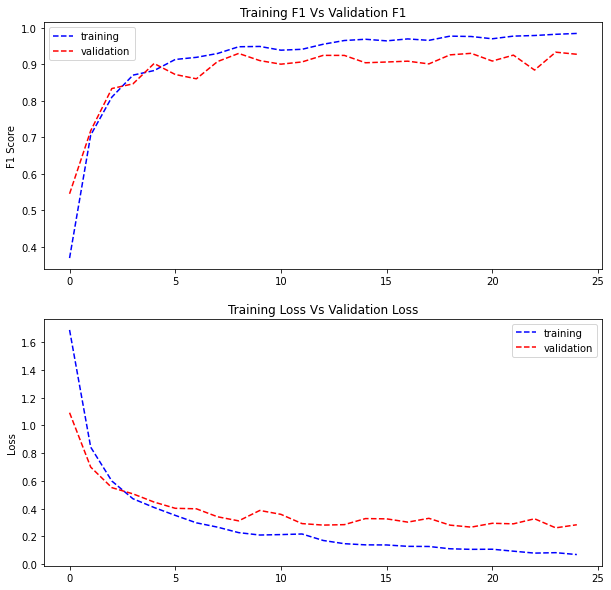

In [19]:
plot_accuracy_loss(model_nn,history_nn) # plot model loss and f1 score

In [20]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               301184    
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
Total params: 303,248
Trainable params: 303,248
Non-trainable params: 0
_________________________________________________________________


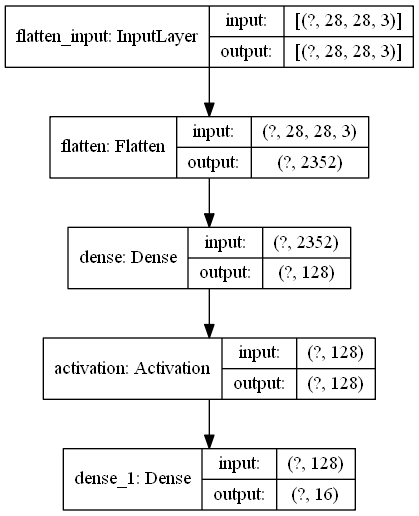

In [21]:
tf.keras.utils.plot_model(model_nn, show_shapes=True)

#### Model 2 - NN (Using Keras, baseline + layer normalisation)

In [22]:
OUTPUT_CLASSES = 16

model_nn_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 3)),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax') # predict a multinomial probability distribution - dependent upon the type of prediction required by the mode
])
model_nn_2.compile(optimizer = 'adam', 
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),  
                 metrics=[tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES,average = 'macro'), # define evaluation metrics, F1 macro and PR AUC
                          tf.keras.metrics.AUC(curve = 'PR',name = 'auc')])
history_nn_2 = model_nn_2.fit_generator(train_generator, # fit on train data
                     epochs = 25, # define epoch size, batch size has been defined prior
                    validation_data=validation_generator, verbose=1) # verbose logs output


Epoch 1/25
70/70 [==============================] - 1s 16ms/step - loss: 1.8332 - f1_score: 0.3122 - auc: 0.5156 - val_loss: 0.9087 - val_f1_score: 0.6507 - val_auc: 0.8676
Epoch 2/25
70/70 [==============================] - 1s 12ms/step - loss: 0.6226 - f1_score: 0.7691 - auc: 0.9174 - val_loss: 0.5625 - val_f1_score: 0.7796 - val_auc: 0.9181
Epoch 3/25
70/70 [==============================] - 1s 12ms/step - loss: 0.3646 - f1_score: 0.8917 - auc: 0.9680 - val_loss: 0.5204 - val_f1_score: 0.8426 - val_auc: 0.9314
Epoch 4/25
70/70 [==============================] - 1s 12ms/step - loss: 0.2880 - f1_score: 0.9139 - auc: 0.9781 - val_loss: 0.2803 - val_f1_score: 0.9115 - val_auc: 0.9764
Epoch 5/25
70/70 [==============================] - 1s 12ms/step - loss: 0.2262 - f1_score: 0.9250 - auc: 0.9850 - val_loss: 0.2862 - val_f1_score: 0.9088 - val_auc: 0.9760
Epoch 6/25
70/70 [==============================] - 1s 12ms/step - loss: 0.1533 - f1_score: 0.9649 - auc: 0.9923 - val_loss: 0.2743 - v

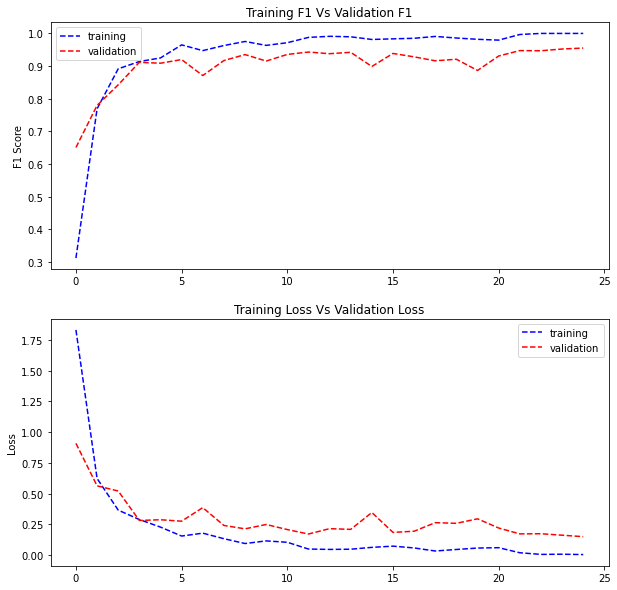

In [23]:
plot_accuracy_loss(model_nn_2,history_nn_2)

In [24]:
model_nn_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               602368    
_________________________________________________________________
layer_normalization (LayerNo (None, 256)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
layer_normalization_1 (Layer (None, 128)               256       
_________________________________________________________________
activation_2 (Activation)    (None, 128)              

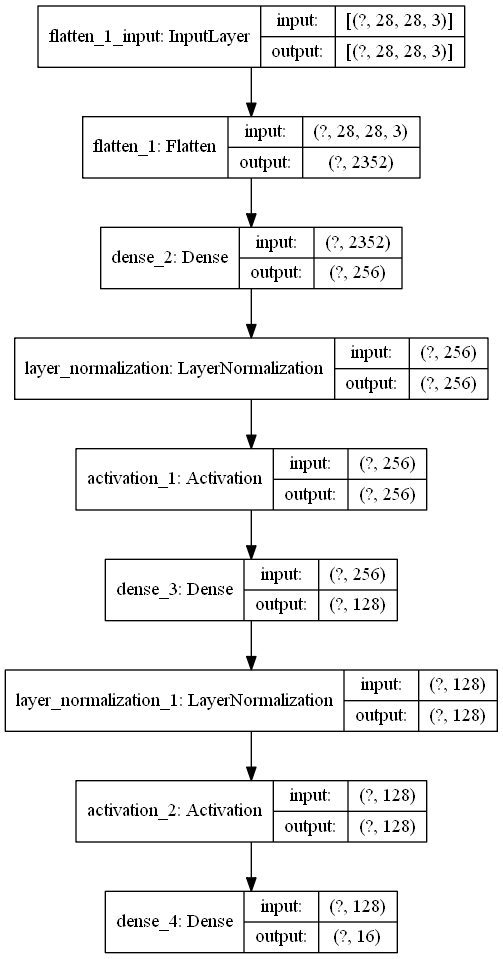

In [25]:
tf.keras.utils.plot_model(model_nn_2, show_shapes=True)

### Algorithm 2: CNN-VGG

#### Model 1 - VGG (baseline)

In [26]:
OUTPUT_CLASSES = 16

model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)), # add convolution layer, "same" results in padding with zeros even to the input.
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'), # define increase in filter size and kernel remains the same
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'), # define increase in filter size and kernel remains the same
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(), # flattens input at this layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'), 
])

model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES,average = 'macro'),
                       tf.keras.metrics.AUC(curve = 'PR',name = 'auc')])

history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=1)


Epoch 1/25
70/70 [==============================] - 4s 57ms/step - loss: 2.3423 - f1_score: 0.1389 - auc: 0.2706 - val_loss: 1.2287 - val_f1_score: 0.4679 - val_auc: 0.6685
Epoch 2/25
70/70 [==============================] - 4s 53ms/step - loss: 0.6257 - f1_score: 0.7431 - auc: 0.8914 - val_loss: 0.3502 - val_f1_score: 0.8862 - val_auc: 0.9576
Epoch 3/25
70/70 [==============================] - 4s 55ms/step - loss: 0.2287 - f1_score: 0.9158 - auc: 0.9783 - val_loss: 0.2095 - val_f1_score: 0.9270 - val_auc: 0.9815
Epoch 4/25
70/70 [==============================] - 4s 54ms/step - loss: 0.1193 - f1_score: 0.9519 - auc: 0.9910 - val_loss: 0.1363 - val_f1_score: 0.9577 - val_auc: 0.9900
Epoch 5/25
70/70 [==============================] - 4s 54ms/step - loss: 0.0559 - f1_score: 0.9817 - auc: 0.9967 - val_loss: 0.1772 - val_f1_score: 0.9453 - val_auc: 0.9832
Epoch 6/25
70/70 [==============================] - 4s 54ms/step - loss: 0.0383 - f1_score: 0.9840 - auc: 0.9978 - val_loss: 0.1228 - v

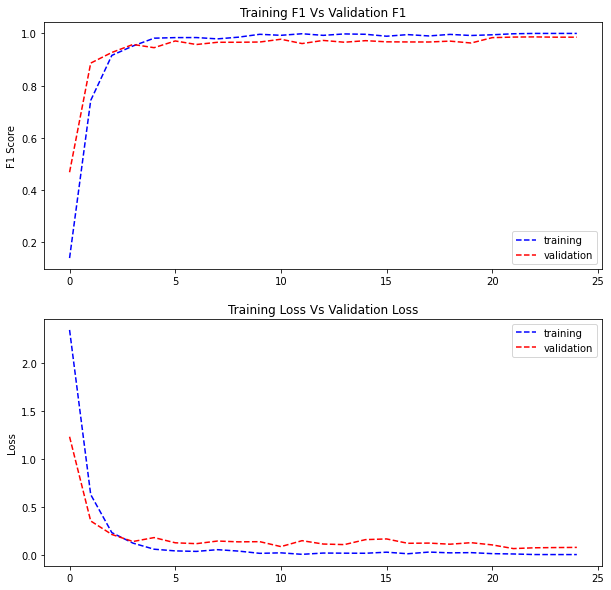

In [27]:
plot_accuracy_loss(model_VGG_1, history_VGG_1) 

In [28]:
model_VGG_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)        

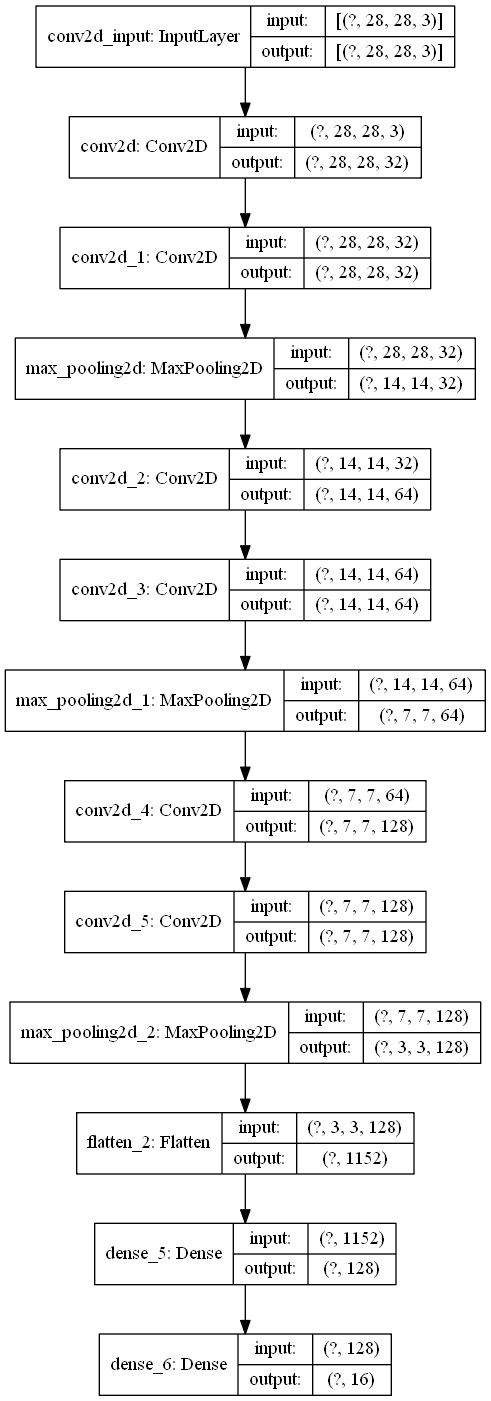

In [29]:
tf.keras.utils.plot_model(model_VGG_1, show_shapes=True)

### Algorithm 3: CNN-LENET

#### Model 1 - LENET (baseline) with Adam Optimizer

In [30]:
OUTPUT_CLASSES = 16

model_leNet_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)), # define input shape
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3)), # define convolution layers
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),  # use max pooling that calculates the maximum, or largest, value in each patch of each feature map 2x2
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax') # predict a multinomial probability distribution - dependent upon the type of prediction required by the mode
])

model_leNet_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=[tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES,average = 'macro'), # define evaluation metrics, F1 macro and PR AUC
                       tf.keras.metrics.AUC(curve = 'PR',name = 'auc')])

history_leNet_1 = model_leNet_1.fit_generator(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=25, verbose=1)


Epoch 1/25
70/70 [==============================] - 1s 20ms/step - loss: 1.9091 - f1_score: 0.3384 - auc: 0.4743 - val_loss: 0.8399 - val_f1_score: 0.6215 - val_auc: 0.8375
Epoch 2/25
70/70 [==============================] - 1s 16ms/step - loss: 0.5223 - f1_score: 0.8154 - auc: 0.9270 - val_loss: 0.3434 - val_f1_score: 0.9144 - val_auc: 0.9641
Epoch 3/25
70/70 [==============================] - 1s 16ms/step - loss: 0.2479 - f1_score: 0.9198 - auc: 0.9786 - val_loss: 0.2841 - val_f1_score: 0.9127 - val_auc: 0.9697
Epoch 4/25
70/70 [==============================] - 1s 16ms/step - loss: 0.1644 - f1_score: 0.9435 - auc: 0.9887 - val_loss: 0.1662 - val_f1_score: 0.9452 - val_auc: 0.9890
Epoch 5/25
70/70 [==============================] - 1s 17ms/step - loss: 0.0964 - f1_score: 0.9691 - auc: 0.9956 - val_loss: 0.1577 - val_f1_score: 0.9499 - val_auc: 0.9891
Epoch 6/25
70/70 [==============================] - 1s 16ms/step - loss: 0.0783 - f1_score: 0.9750 - auc: 0.9963 - val_loss: 0.1796 - v

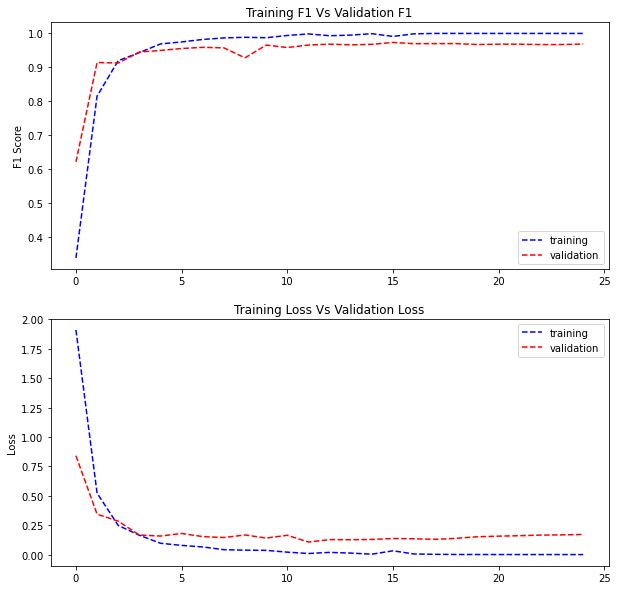

In [31]:
plot_accuracy_loss(model_leNet_1, history_leNet_1) 

In [32]:
model_leNet_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_4 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 64)         

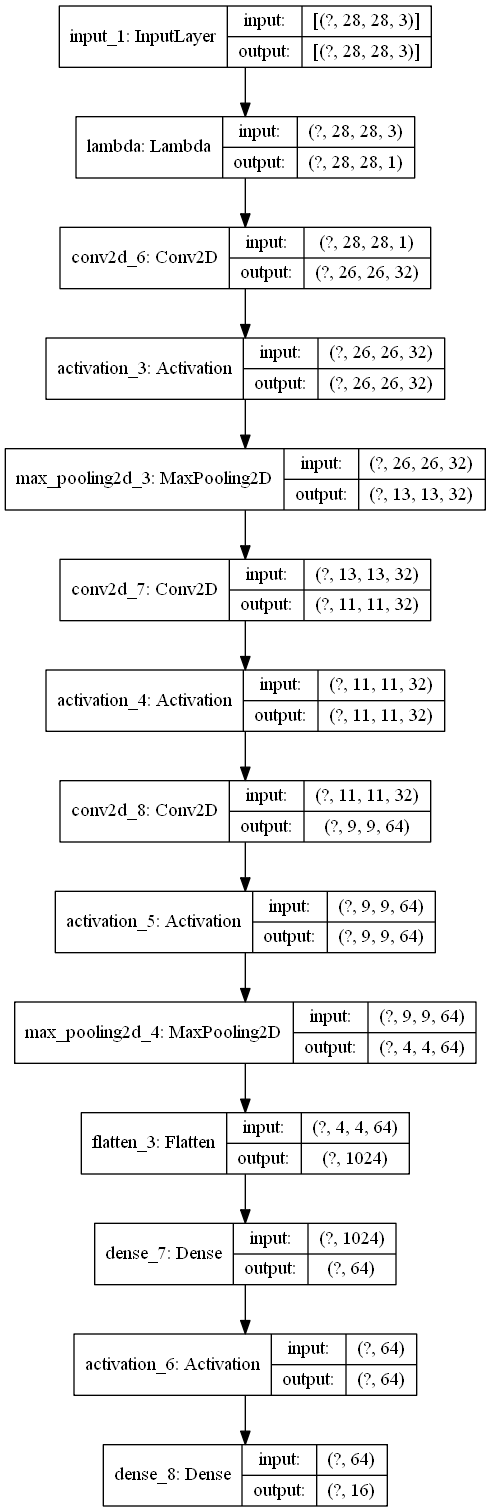

In [33]:
tf.keras.utils.plot_model(model_leNet_1, show_shapes=True)

#### Model 2 - LENET (baseline + batch normalization + dropout) with Adam Optimizer

In [34]:
OUTPUT_CLASSES = 16

model_leNet_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)), # define input shape
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), # normalization layer to speed up training
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128), # changed from 64 to 128
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5), # tested with dropout values [0.3 to 0.8] performance is better with dropout, prevent overfitting
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax') # predict a multinomial probability distribution - dependent upon the type of prediction required by the mode
])

model_leNet_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES,average = 'macro'), # define evaluation metrics, F1 macro and PR AUC
                       tf.keras.metrics.AUC(curve = 'PR',name = 'auc')])

history_leNet_2 = model_leNet_2.fit_generator(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=25, verbose=1)


Epoch 1/25
70/70 [==============================] - 2s 28ms/step - loss: 1.0201 - f1_score: 0.6473 - auc: 0.8014 - val_loss: 2.7461 - val_f1_score: 0.0067 - val_auc: 0.1431
Epoch 2/25
70/70 [==============================] - 2s 23ms/step - loss: 0.2142 - f1_score: 0.9303 - auc: 0.9835 - val_loss: 3.6720 - val_f1_score: 0.0067 - val_auc: 0.1487
Epoch 3/25
70/70 [==============================] - 2s 23ms/step - loss: 0.1522 - f1_score: 0.9450 - auc: 0.9919 - val_loss: 3.3374 - val_f1_score: 0.0351 - val_auc: 0.1835
Epoch 4/25
70/70 [==============================] - 2s 25ms/step - loss: 0.0785 - f1_score: 0.9771 - auc: 0.9978 - val_loss: 2.3674 - val_f1_score: 0.1870 - val_auc: 0.2751
Epoch 5/25
70/70 [==============================] - 2s 24ms/step - loss: 0.0506 - f1_score: 0.9879 - auc: 0.9991 - val_loss: 1.8093 - val_f1_score: 0.4031 - val_auc: 0.4144
Epoch 6/25
70/70 [==============================] - 2s 24ms/step - loss: 0.0456 - f1_score: 0.9886 - auc: 0.9995 - val_loss: 0.8090 - v

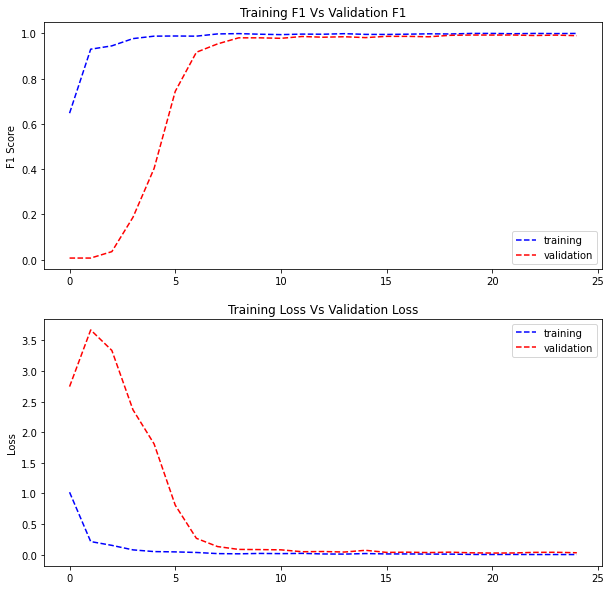

In [35]:
plot_accuracy_loss(model_leNet_2, history_leNet_2) 

In [36]:
model_leNet_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_7 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 11, 11, 32)       

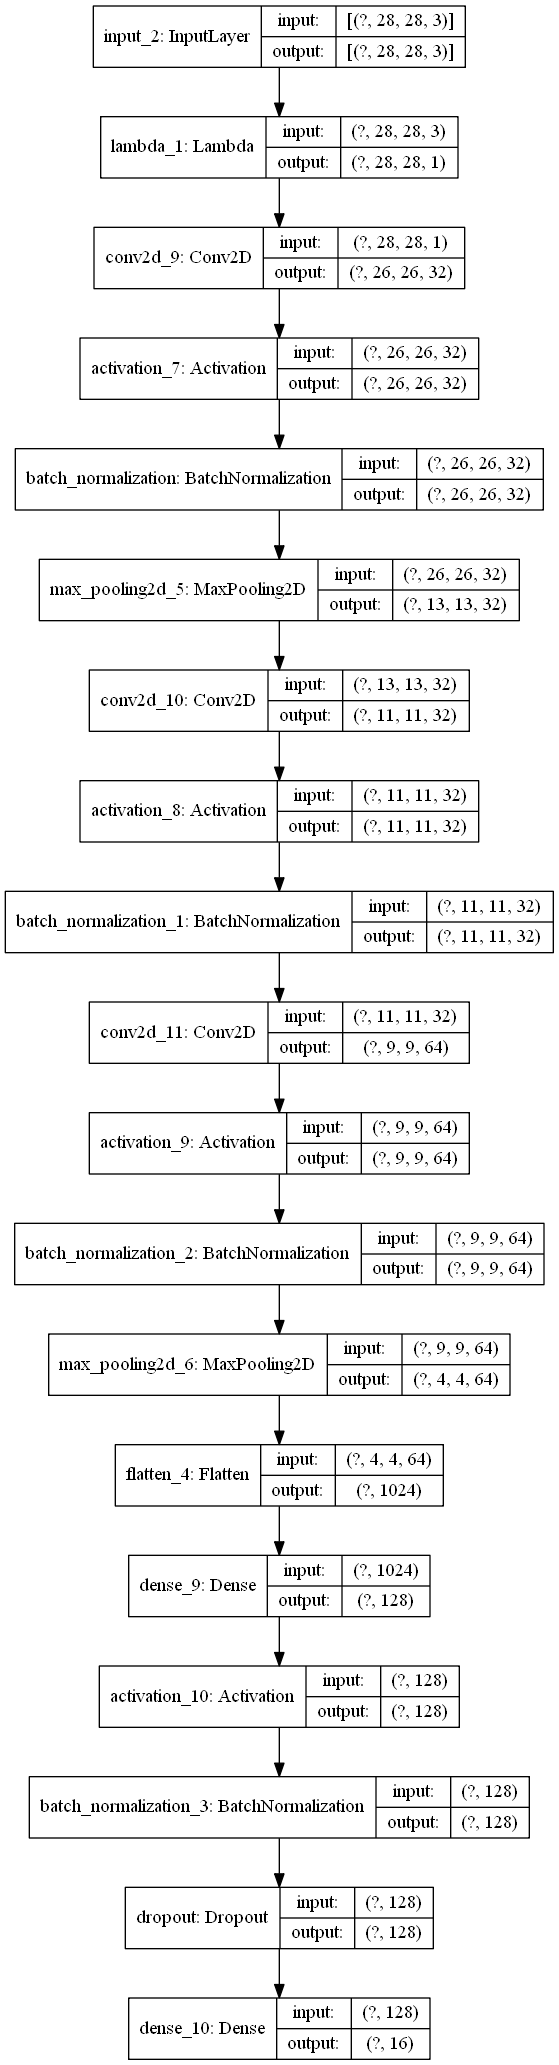

In [37]:
tf.keras.utils.plot_model(model_leNet_2, show_shapes=True)

#### Model 3 - LENET (baseline + batch normalization) with SGD Optimizer

In [38]:
OUTPUT_CLASSES = 16

model_leNet_SGD = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)), # define input shape
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'), # If the resultant value from the node is positive, the output will be the same positive value, and if the resultant value is negative, the output will be zero.
    tf.keras.layers.BatchNormalization(), # normalization layer to speed up training
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), # normalization layer to speed up training
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), # normalization layer to speed up training
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128), # changed from 64 to 128
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), # normalization layer to speed up training
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax') # predict a multinomial probability distribution - dependent upon the type of prediction required by the mode
])

model_leNet_SGD.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES,average = 'macro'), # define evaluation metrics, F1 macro and PR AUC
                       tf.keras.metrics.AUC(curve = 'PR',name = 'auc')])

history_leNet_SGD = model_leNet_SGD.fit_generator(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=100, verbose=1)


Epoch 1/100
70/70 [==============================] - 2s 28ms/step - loss: 0.9741 - f1_score: 0.6744 - auc: 0.8261 - val_loss: 2.9365 - val_f1_score: 0.0067 - val_auc: 0.0805
Epoch 2/100
70/70 [==============================] - 2s 23ms/step - loss: 0.2778 - f1_score: 0.9357 - auc: 0.9856 - val_loss: 2.9298 - val_f1_score: 0.0067 - val_auc: 0.1563
Epoch 3/100
70/70 [==============================] - 2s 23ms/step - loss: 0.1657 - f1_score: 0.9728 - auc: 0.9954 - val_loss: 2.5163 - val_f1_score: 0.0086 - val_auc: 0.2157
Epoch 4/100
70/70 [==============================] - 2s 24ms/step - loss: 0.1127 - f1_score: 0.9814 - auc: 0.9982 - val_loss: 1.7980 - val_f1_score: 0.2114 - val_auc: 0.3607
Epoch 5/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0871 - f1_score: 0.9914 - auc: 0.9991 - val_loss: 1.1101 - val_f1_score: 0.6259 - val_auc: 0.7906
Epoch 6/100
70/70 [==============================] - 2s 24ms/step - loss: 0.0696 - f1_score: 0.9892 - auc: 0.9995 - val_loss: 0.72

Epoch 48/100
70/70 [==============================] - 2s 24ms/step - loss: 0.0047 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0637 - val_f1_score: 0.9792 - val_auc: 0.9982
Epoch 49/100
70/70 [==============================] - 2s 27ms/step - loss: 0.0048 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0636 - val_f1_score: 0.9769 - val_auc: 0.9982
Epoch 50/100
70/70 [==============================] - 2s 25ms/step - loss: 0.0053 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0624 - val_f1_score: 0.9801 - val_auc: 0.9983
Epoch 51/100
70/70 [==============================] - 2s 24ms/step - loss: 0.0048 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0591 - val_f1_score: 0.9815 - val_auc: 0.9986
Epoch 52/100
70/70 [==============================] - 2s 25ms/step - loss: 0.0043 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0616 - val_f1_score: 0.9810 - val_auc: 0.9982
Epoch 53/100
70/70 [==============================] - 2s 25ms/step - loss: 0.0046 - f1_score: 1.0000 - auc: 1.0000 - val_loss

Epoch 95/100
70/70 [==============================] - 2s 25ms/step - loss: 0.0024 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0523 - val_f1_score: 0.9889 - val_auc: 0.9988
Epoch 96/100
70/70 [==============================] - 2s 25ms/step - loss: 0.0022 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0562 - val_f1_score: 0.9841 - val_auc: 0.9985
Epoch 97/100
70/70 [==============================] - 2s 26ms/step - loss: 0.0023 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0568 - val_f1_score: 0.9863 - val_auc: 0.9984
Epoch 98/100
70/70 [==============================] - 2s 25ms/step - loss: 0.0021 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0532 - val_f1_score: 0.9865 - val_auc: 0.9986
Epoch 99/100
70/70 [==============================] - 2s 26ms/step - loss: 0.0021 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0548 - val_f1_score: 0.9872 - val_auc: 0.9986
Epoch 100/100
70/70 [==============================] - 2s 25ms/step - loss: 0.0021 - f1_score: 1.0000 - auc: 1.0000 - val_los

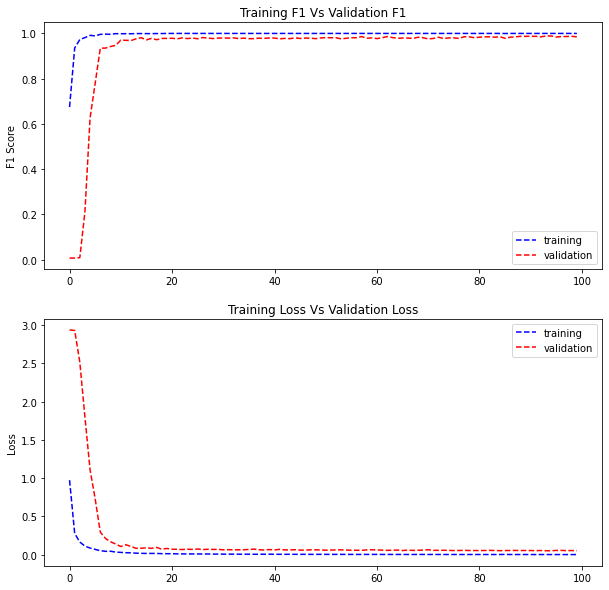

In [39]:
plot_accuracy_loss(model_leNet_SGD, history_leNet_SGD) 

In [40]:
model_leNet_SGD.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_11 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 11, 11, 32)       

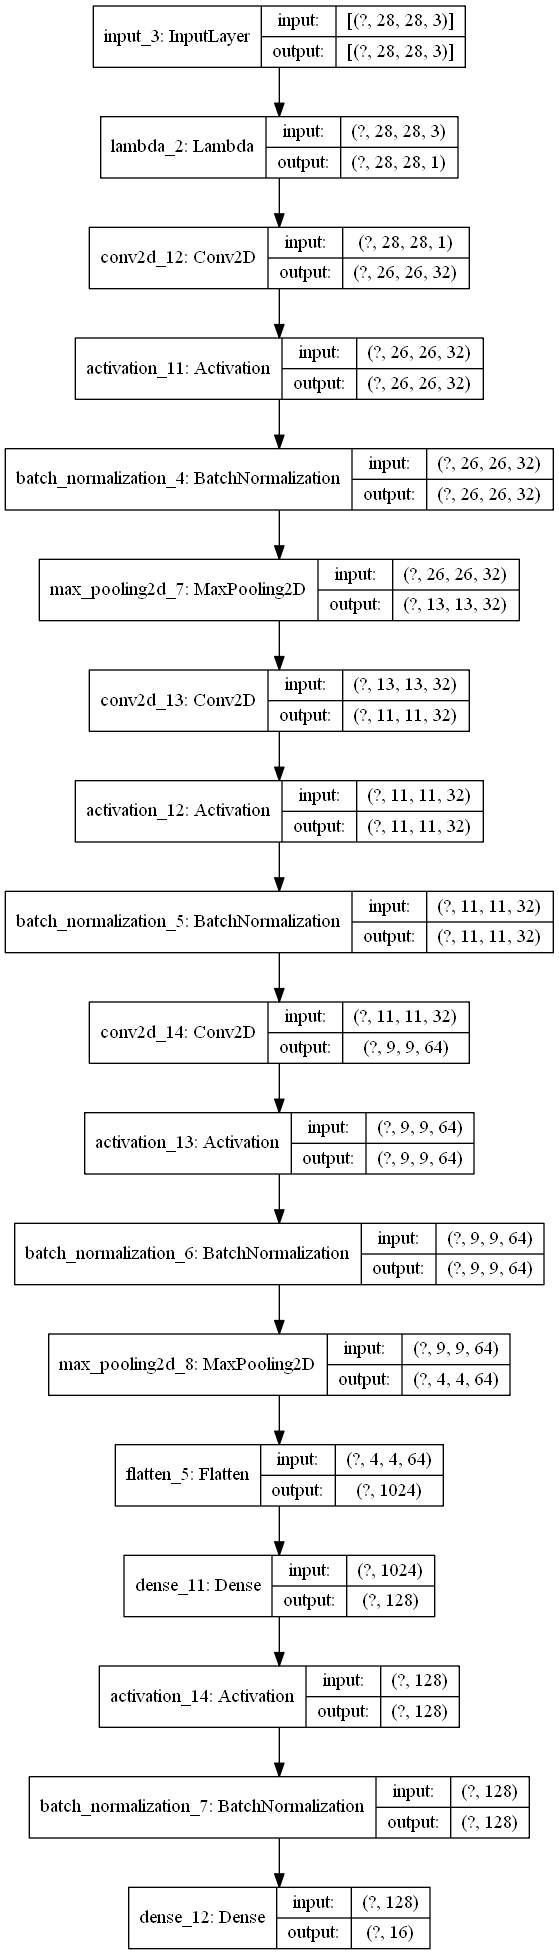

In [41]:
tf.keras.utils.plot_model(model_leNet_SGD, show_shapes=True)

### Model Evaluation

#### Traffic Sign Types

In [42]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data, # load in from the test data based on sign types
        directory='./',
        x_col="image_path",
        shuffle=False,
        y_col="label",
        target_size=(28, 28), # image size to be defined
        batch_size=batch_size,
        class_mode='categorical') # multiclass categorical

Found 740 validated image filenames belonging to 16 classes.


In [43]:
model_nn.evaluate(test_generator) # check results of evaluation on test data

740/740 [==============================] - 4s 5ms/step - loss: 0.2637 - f1_score: 0.9287 - auc: 0.9777


[0.263698011636734, 0.9286863207817078, 0.9776674509048462]

In [44]:
model_nn_2.evaluate(test_generator)

740/740 [==============================] - 1s 1ms/step - loss: 0.1385 - f1_score: 0.9570 - auc: 0.9865


[0.13851462304592133, 0.9569798707962036, 0.9865044951438904]

In [45]:
model_VGG_1.evaluate(test_generator)

740/740 [==============================] - 1s 2ms/step - loss: 0.0905 - f1_score: 0.9819 - auc: 0.9927


[0.09054139256477356, 0.9818547964096069, 0.9927451014518738]

In [46]:
model_leNet_1.evaluate(test_generator)

740/740 [==============================] - 1s 1ms/step - loss: 0.1786 - f1_score: 0.9717 - auc: 0.9823


[0.17864298820495605, 0.971707284450531, 0.9823182225227356]

In [47]:
model_leNet_2.evaluate(test_generator)

740/740 [==============================] - 1s 1ms/step - loss: 0.0430 - f1_score: 0.9879 - auc: 0.9975


[0.04299890249967575, 0.9879424571990967, 0.9975062012672424]

In [48]:
model_leNet_SGD.evaluate(test_generator)

740/740 [==============================] - 1s 1ms/step - loss: 0.0565 - f1_score: 0.9772 - auc: 0.9984


[0.0564827024936676, 0.977188229560852, 0.9984456896781921]

## Models for Traffic Sign Shapes

### Algorithm 1: Neural Networks

#### Model 1 - NN (Using Keras)

In [49]:
OUTPUT_CLASSES = 5 # there are 5 classes for shapes, round, hex, triangle, square, diamond

model_nn_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 3)), # define input shape of data
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax') # predict a multinomial probability distribution - dependent upon the type of prediction required
])
model_nn_shape.compile(optimizer = 'adam', 
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),  
                 metrics=[tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES,average = 'macro'), # define evaluation metrics, F1 macro and PR AUC
                          tf.keras.metrics.AUC(curve = 'PR',name = 'auc')])
history_nn_shape = model_nn_shape.fit_generator(train_generator_shape, 
                     epochs = 25, 
                    validation_data=validation_generator_shape, verbose=1)

Epoch 1/25
70/70 [==============================] - 1s 16ms/step - loss: 0.8481 - f1_score: 0.4953 - auc: 0.7765 - val_loss: 0.4993 - val_f1_score: 0.6861 - val_auc: 0.9289
Epoch 2/25
70/70 [==============================] - 1s 12ms/step - loss: 0.4713 - f1_score: 0.7235 - auc: 0.9210 - val_loss: 0.4014 - val_f1_score: 0.6986 - val_auc: 0.9456
Epoch 3/25
70/70 [==============================] - 1s 11ms/step - loss: 0.3578 - f1_score: 0.7895 - auc: 0.9518 - val_loss: 0.3573 - val_f1_score: 0.8140 - val_auc: 0.9464
Epoch 4/25
70/70 [==============================] - 1s 11ms/step - loss: 0.2729 - f1_score: 0.8751 - auc: 0.9717 - val_loss: 0.2615 - val_f1_score: 0.8379 - val_auc: 0.9726
Epoch 5/25
70/70 [==============================] - 1s 11ms/step - loss: 0.2313 - f1_score: 0.8738 - auc: 0.9785 - val_loss: 0.2199 - val_f1_score: 0.8904 - val_auc: 0.9830
Epoch 6/25
70/70 [==============================] - 1s 12ms/step - loss: 0.1977 - f1_score: 0.9025 - auc: 0.9834 - val_loss: 0.2582 - v

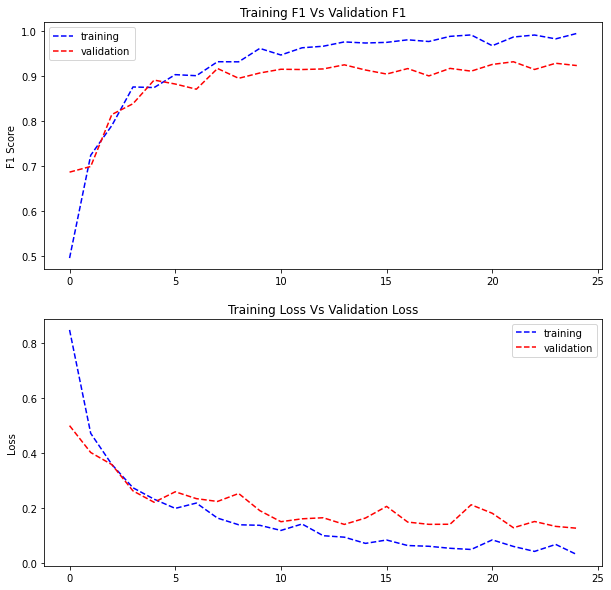

In [50]:
plot_accuracy_loss(model_nn_shape,history_nn_shape)

In [51]:
model_nn_shape.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               301184    
_________________________________________________________________
activation_15 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 645       
Total params: 301,829
Trainable params: 301,829
Non-trainable params: 0
_________________________________________________________________


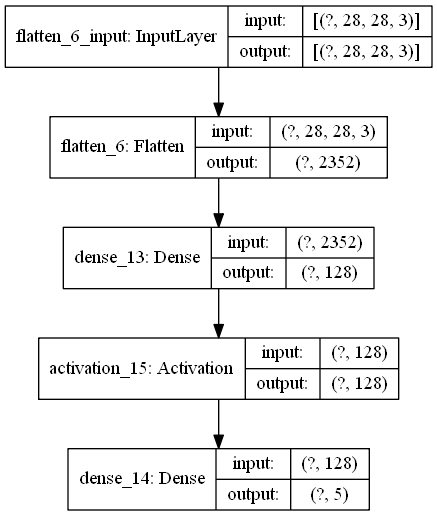

In [52]:
tf.keras.utils.plot_model(model_nn_shape, show_shapes=True)

#### Model 2 - NN (Using Keras, baseline + layer normalisation)

In [53]:
OUTPUT_CLASSES = 5

model_nn_2_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 3)), # define input shape of data
    tf.keras.layers.Dense(256),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax') # predict a multinomial probability distribution - dependent upon the type of prediction required
])
model_nn_2_shape.compile(optimizer = 'adam', 
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),  
                 metrics=[tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES,average = 'macro'), # define evaluation metrics, F1 macro and PR AUC
                          tf.keras.metrics.AUC(curve = 'PR',name = 'auc')])
history_nn_2_shape = model_nn_2_shape.fit_generator(train_generator_shape, 
                     epochs = 25, 
                    validation_data=validation_generator_shape, verbose=1)

Epoch 1/25
70/70 [==============================] - 1s 18ms/step - loss: 0.9599 - f1_score: 0.4135 - auc: 0.6921 - val_loss: 0.5534 - val_f1_score: 0.6328 - val_auc: 0.9018
Epoch 2/25
70/70 [==============================] - 1s 12ms/step - loss: 0.4437 - f1_score: 0.6823 - auc: 0.9211 - val_loss: 0.3099 - val_f1_score: 0.7129 - val_auc: 0.9578
Epoch 3/25
70/70 [==============================] - 1s 13ms/step - loss: 0.2640 - f1_score: 0.8241 - auc: 0.9694 - val_loss: 0.2083 - val_f1_score: 0.8473 - val_auc: 0.9805
Epoch 4/25
70/70 [==============================] - 1s 15ms/step - loss: 0.1967 - f1_score: 0.8675 - auc: 0.9826 - val_loss: 0.1636 - val_f1_score: 0.8665 - val_auc: 0.9876
Epoch 5/25
70/70 [==============================] - 1s 16ms/step - loss: 0.1898 - f1_score: 0.9025 - auc: 0.9820 - val_loss: 0.2174 - val_f1_score: 0.8596 - val_auc: 0.9786
Epoch 6/25
70/70 [==============================] - 1s 14ms/step - loss: 0.1435 - f1_score: 0.9261 - auc: 0.9896 - val_loss: 0.1487 - v

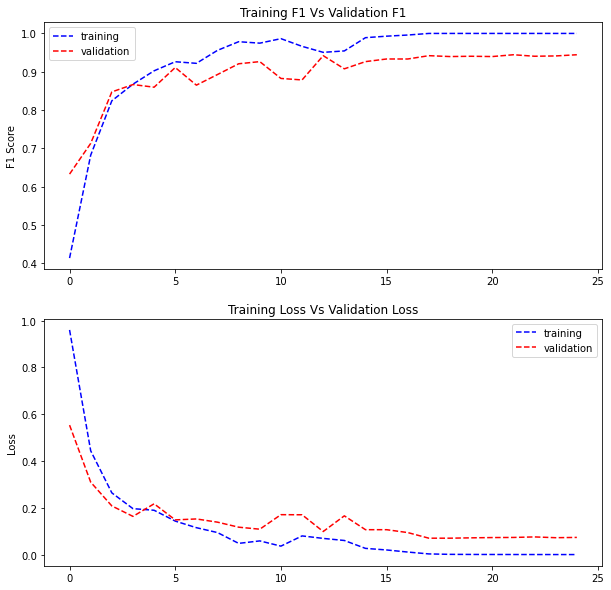

In [54]:
plot_accuracy_loss(model_nn_2_shape,history_nn_2_shape)

In [55]:
model_nn_2_shape.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               602368    
_________________________________________________________________
layer_normalization_2 (Layer (None, 256)               512       
_________________________________________________________________
activation_16 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
layer_normalization_3 (Layer (None, 128)               256       
_________________________________________________________________
activation_17 (Activation)   (None, 128)              

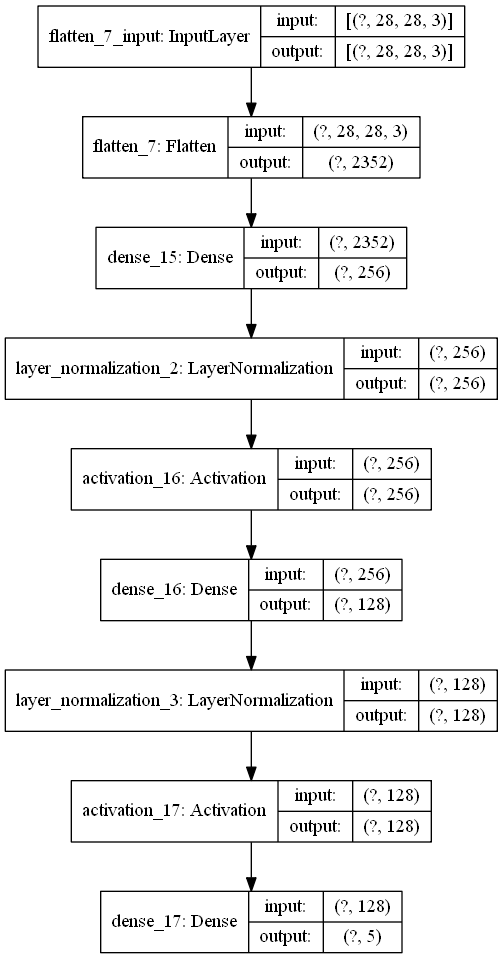

In [56]:
tf.keras.utils.plot_model(model_nn_2_shape, show_shapes=True)

### Algorithm 2: CNN-VGG

#### Model 1 - VGG (baseline)

In [57]:
OUTPUT_CLASSES = 5

model_VGG_1_shape = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),  # add convolution layer, "same" results in padding with zeros even to the input.
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'), # predict a multinomial probability distribution - dependent upon the type of prediction required
])

model_VGG_1_shape.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES,average = 'macro'), # define evaluation metrics, F1 macro and PR AUC
                       tf.keras.metrics.AUC(curve = 'PR',name = 'auc')])

history_VGG_1_shape = model_VGG_1_shape.fit_generator(train_generator_shape, validation_data = validation_generator_shape, epochs=25, verbose=1)


Epoch 1/25
70/70 [==============================] - 5s 76ms/step - loss: 1.0624 - f1_score: 0.3630 - auc: 0.6405 - val_loss: 0.4393 - val_f1_score: 0.6441 - val_auc: 0.9251
Epoch 2/25
70/70 [==============================] - 4s 62ms/step - loss: 0.2137 - f1_score: 0.8151 - auc: 0.9773 - val_loss: 0.0836 - val_f1_score: 0.9282 - val_auc: 0.9977
Epoch 3/25
70/70 [==============================] - 4s 59ms/step - loss: 0.0570 - f1_score: 0.9434 - auc: 0.9974 - val_loss: 0.2064 - val_f1_score: 0.8989 - val_auc: 0.9736
Epoch 4/25
70/70 [==============================] - 4s 63ms/step - loss: 0.0570 - f1_score: 0.9671 - auc: 0.9960 - val_loss: 0.0379 - val_f1_score: 0.9871 - val_auc: 0.9993
Epoch 5/25
70/70 [==============================] - 4s 61ms/step - loss: 0.0163 - f1_score: 0.9847 - auc: 0.9996 - val_loss: 0.0420 - val_f1_score: 0.9767 - val_auc: 0.9977
Epoch 6/25
70/70 [==============================] - 4s 61ms/step - loss: 0.0056 - f1_score: 0.9986 - auc: 1.0000 - val_loss: 0.0547 - v

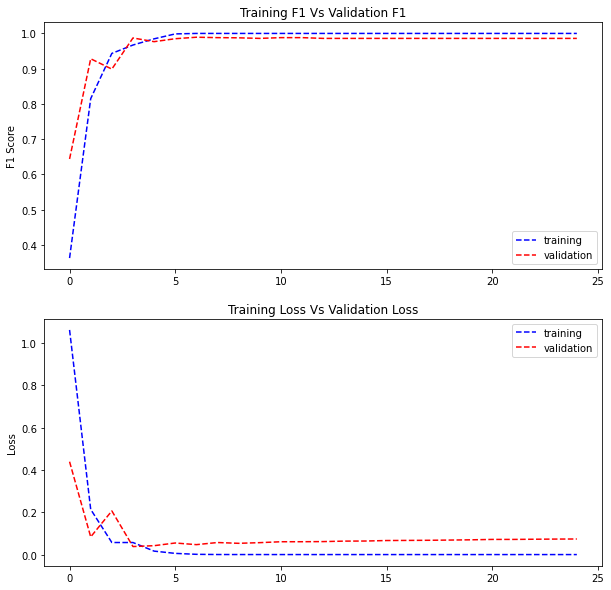

In [58]:
plot_accuracy_loss(model_VGG_1_shape,history_VGG_1_shape)

In [59]:
model_VGG_1_shape.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 128)        

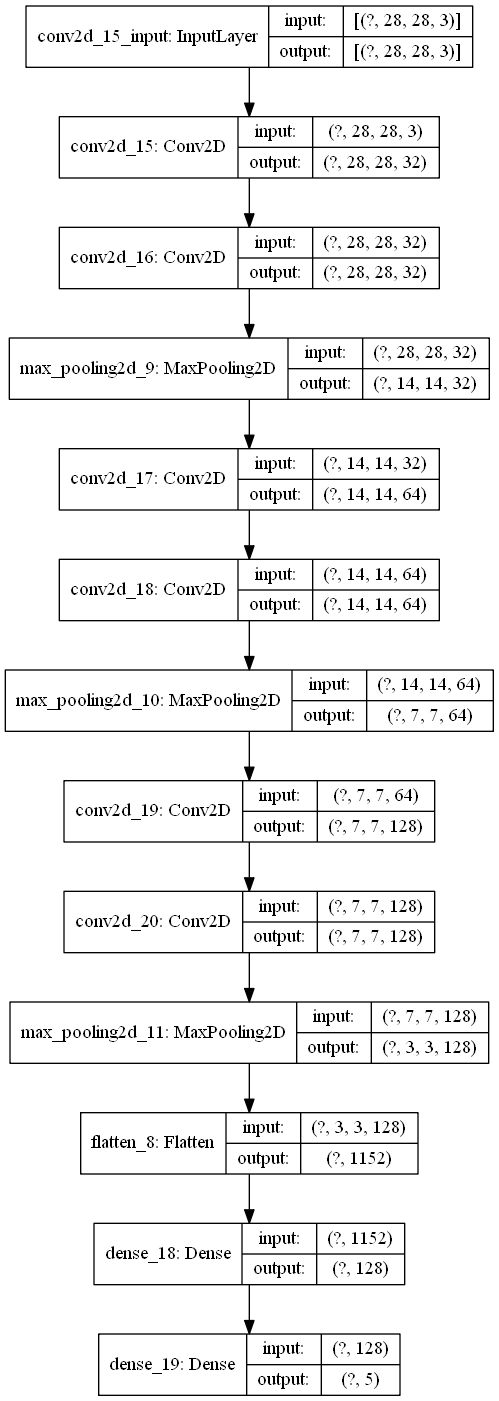

In [60]:
tf.keras.utils.plot_model(model_VGG_1_shape, show_shapes=True)

### Algorithm 3: CNN-LENET

#### Model 1 - LENET (baseline) with Adam Optimizer

In [61]:
OUTPUT_CLASSES = 5

model_leNet_1_shape = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)), # define input shape of data
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax') # predict a multinomial probability distribution - dependent upon the type of prediction required
])

model_leNet_1_shape.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES,average = 'macro'), # define evaluation metrics, F1 macro and PR AUC
                       tf.keras.metrics.AUC(curve = 'PR',name = 'auc')])

history_leNet_1_shape = model_leNet_1_shape.fit_generator(train_generator_shape, 
                                    validation_data = validation_generator_shape, 
                                    epochs=25, verbose=1)


Epoch 1/25
70/70 [==============================] - 2s 23ms/step - loss: 1.0343 - f1_score: 0.3531 - auc: 0.6515 - val_loss: 0.6023 - val_f1_score: 0.6475 - val_auc: 0.8967
Epoch 2/25
70/70 [==============================] - 1s 17ms/step - loss: 0.3598 - f1_score: 0.7075 - auc: 0.9473 - val_loss: 0.1774 - val_f1_score: 0.7539 - val_auc: 0.9883
Epoch 3/25
70/70 [==============================] - 1s 17ms/step - loss: 0.1548 - f1_score: 0.8872 - auc: 0.9885 - val_loss: 0.1225 - val_f1_score: 0.9488 - val_auc: 0.9962
Epoch 4/25
70/70 [==============================] - 1s 17ms/step - loss: 0.0744 - f1_score: 0.9417 - auc: 0.9980 - val_loss: 0.0571 - val_f1_score: 0.9717 - val_auc: 0.9985
Epoch 5/25
70/70 [==============================] - 1s 17ms/step - loss: 0.0480 - f1_score: 0.9629 - auc: 0.9989 - val_loss: 0.0587 - val_f1_score: 0.9748 - val_auc: 0.9985
Epoch 6/25
70/70 [==============================] - 1s 18ms/step - loss: 0.0363 - f1_score: 0.9685 - auc: 0.9995 - val_loss: 0.0351 - v

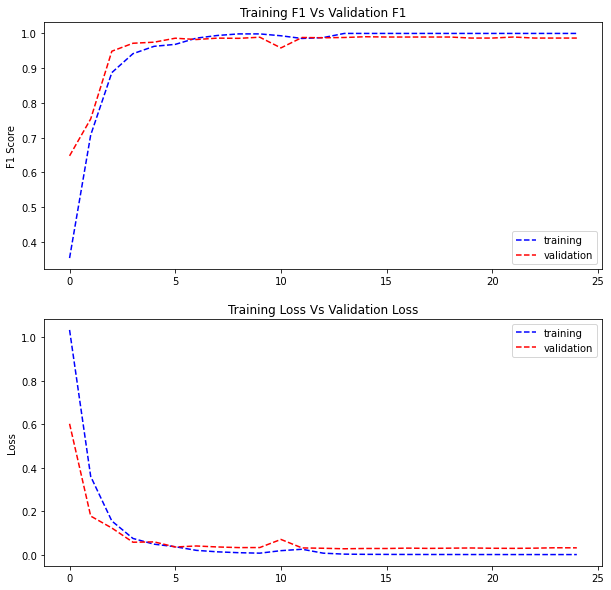

In [62]:
plot_accuracy_loss(model_leNet_1_shape, history_leNet_1_shape) 

In [63]:
model_leNet_1_shape.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_18 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 9, 9, 64)         

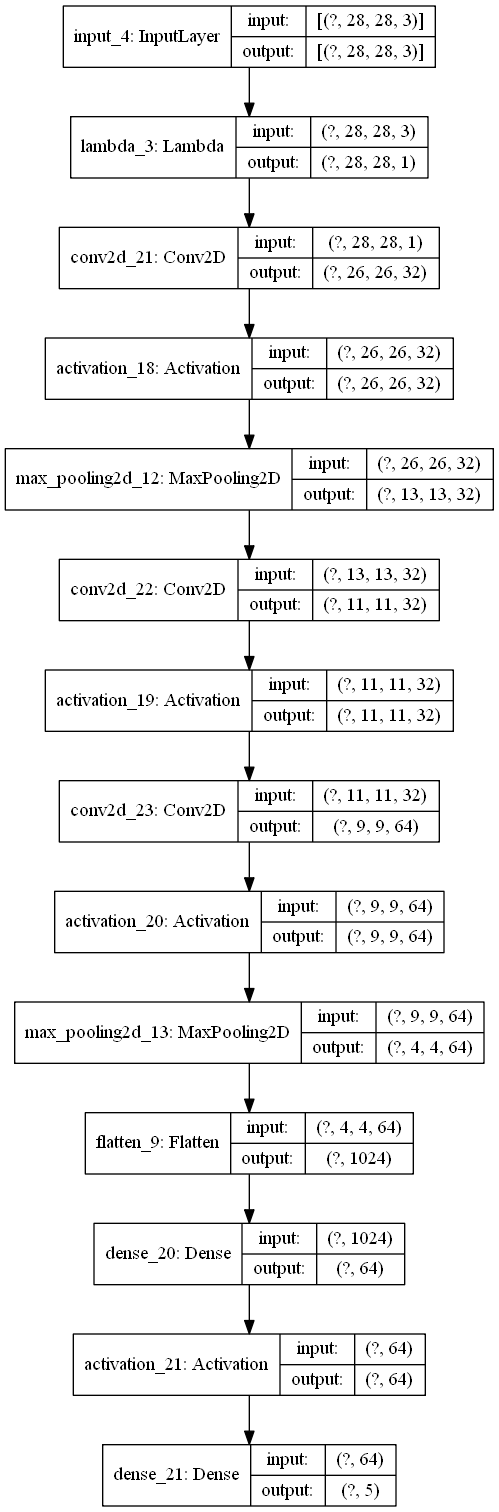

In [64]:
tf.keras.utils.plot_model(model_leNet_1_shape, show_shapes=True)

#### Model 2 - LENET (baseline + batch normalization + dropout) with Adam Optimizer

In [65]:
OUTPUT_CLASSES = 5

model_leNet_2_shape = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128), # changed from 64 to 128
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5), # tested with dropout values [0.3 to 0.8] performance is better with dropout
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax') # predict a multinomial probability distribution - dependent upon the type of prediction required
])

model_leNet_2_shape.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES,average = 'macro'), # define evaluation metrics, F1 macro and PR AUC
                       tf.keras.metrics.AUC(curve = 'PR',name = 'auc')])

history_leNet_2_shape = model_leNet_2_shape.fit_generator(train_generator_shape, 
                                    validation_data = validation_generator_shape, 
                                    epochs=25, verbose=1)


Epoch 1/25
70/70 [==============================] - 2s 29ms/step - loss: 0.5798 - f1_score: 0.6799 - auc: 0.8934 - val_loss: 1.3232 - val_f1_score: 0.1343 - val_auc: 0.6896
Epoch 2/25
70/70 [==============================] - 2s 23ms/step - loss: 0.1332 - f1_score: 0.9044 - auc: 0.9919 - val_loss: 1.7113 - val_f1_score: 0.1343 - val_auc: 0.6943
Epoch 3/25
70/70 [==============================] - 2s 23ms/step - loss: 0.0924 - f1_score: 0.9427 - auc: 0.9956 - val_loss: 1.4325 - val_f1_score: 0.1366 - val_auc: 0.6941
Epoch 4/25
70/70 [==============================] - 2s 24ms/step - loss: 0.0588 - f1_score: 0.9679 - auc: 0.9986 - val_loss: 1.3982 - val_f1_score: 0.1797 - val_auc: 0.7578
Epoch 5/25
70/70 [==============================] - 2s 24ms/step - loss: 0.0452 - f1_score: 0.9664 - auc: 0.9990 - val_loss: 0.9923 - val_f1_score: 0.4072 - val_auc: 0.8203
Epoch 6/25
70/70 [==============================] - 2s 24ms/step - loss: 0.0321 - f1_score: 0.9849 - auc: 0.9995 - val_loss: 0.2375 - v

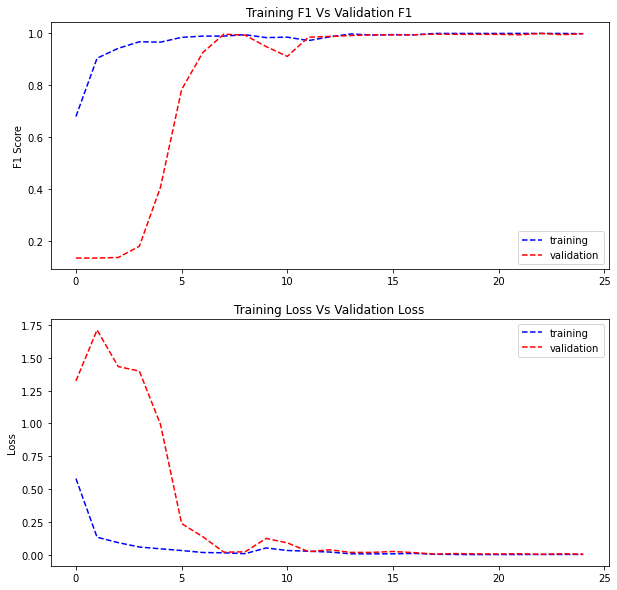

In [66]:
plot_accuracy_loss(model_leNet_2_shape, history_leNet_2_shape) 

In [67]:
model_leNet_2_shape.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_22 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_23 (Activation)   (None, 11, 11, 32)      

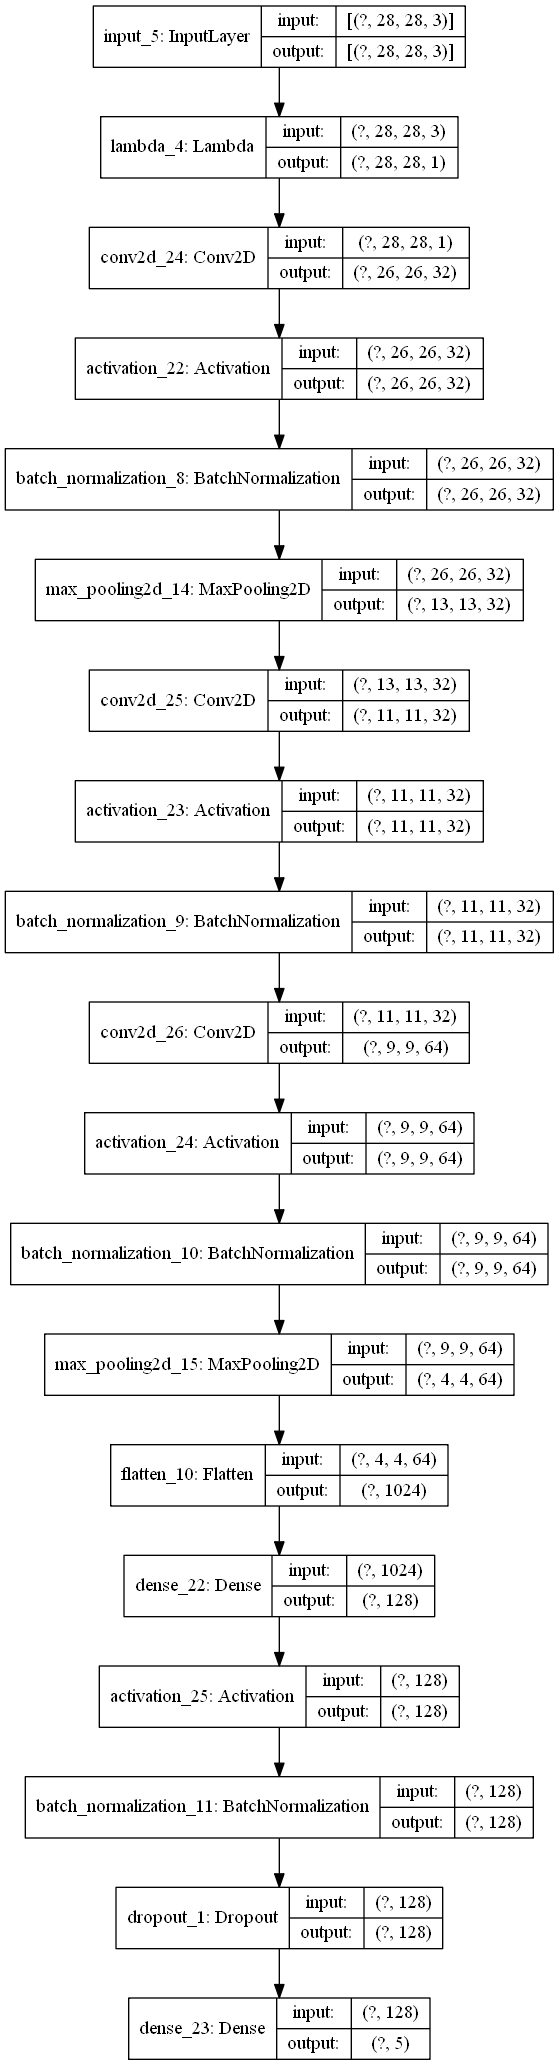

In [68]:
tf.keras.utils.plot_model(model_leNet_2_shape, show_shapes=True)

#### Model 3 - LENET (baseline + batch normalization) with SGD Optimizer

In [88]:
OUTPUT_CLASSES = 5

model_leNet_SGD_shape = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)), # define input shape of data
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), # normalization layer to speed up training
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), # normalization layer to speed up training
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), # normalization layer to speed up training
    tf.keras.layers.MaxPool2D(pool_size=(2,2)), 
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128), # changed from 64 to 128
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax') # predict a multinomial probability distribution - dependent upon the type of prediction required
])

model_leNet_SGD_shape.compile(optimizer='SGD', # test out SGD over ADAM to see if performance is better
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tfa.metrics.F1Score(num_classes=OUTPUT_CLASSES,average = 'macro'),
                       tf.keras.metrics.AUC(curve = 'PR',name = 'auc')])

history_leNet_SGD_shape = model_leNet_SGD_shape.fit_generator(train_generator_shape, 
                                    validation_data = validation_generator_shape, 
                                    epochs=100, verbose=1)


Epoch 1/100
70/70 [==============================] - 2s 30ms/step - loss: 0.4839 - f1_score: 0.7062 - auc: 0.9263 - val_loss: 1.3288 - val_f1_score: 0.1343 - val_auc: 0.6335
Epoch 2/100
70/70 [==============================] - 2s 23ms/step - loss: 0.1549 - f1_score: 0.9145 - auc: 0.9923 - val_loss: 1.1832 - val_f1_score: 0.1343 - val_auc: 0.6919
Epoch 3/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0910 - f1_score: 0.9399 - auc: 0.9967 - val_loss: 1.1039 - val_f1_score: 0.2186 - val_auc: 0.7097
Epoch 4/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0694 - f1_score: 0.9724 - auc: 0.9988 - val_loss: 0.7568 - val_f1_score: 0.4758 - val_auc: 0.8245
Epoch 5/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0462 - f1_score: 0.9746 - auc: 0.9998 - val_loss: 0.4648 - val_f1_score: 0.6600 - val_auc: 0.9277
Epoch 6/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0398 - f1_score: 0.9917 - auc: 0.9999 - val_loss: 0.24

Epoch 48/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0029 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0286 - val_f1_score: 0.9895 - val_auc: 0.9996
Epoch 49/100
70/70 [==============================] - 2s 24ms/step - loss: 0.0026 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0257 - val_f1_score: 0.9752 - val_auc: 0.9997
Epoch 50/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0028 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0255 - val_f1_score: 0.9752 - val_auc: 0.9997
Epoch 51/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0036 - f1_score: 0.9997 - auc: 1.0000 - val_loss: 0.0268 - val_f1_score: 0.9713 - val_auc: 0.9997
Epoch 52/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0030 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0295 - val_f1_score: 0.9867 - val_auc: 0.9996
Epoch 53/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0027 - f1_score: 1.0000 - auc: 1.0000 - val_loss

Epoch 95/100
70/70 [==============================] - 2s 25ms/step - loss: 0.0016 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0320 - val_f1_score: 0.9683 - val_auc: 0.9996
Epoch 96/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0017 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0332 - val_f1_score: 0.9840 - val_auc: 0.9995
Epoch 97/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0014 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0301 - val_f1_score: 0.9546 - val_auc: 0.9996
Epoch 98/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0016 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0311 - val_f1_score: 0.9546 - val_auc: 0.9996
Epoch 99/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0017 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0307 - val_f1_score: 0.9697 - val_auc: 0.9996
Epoch 100/100
70/70 [==============================] - 2s 24ms/step - loss: 0.0015 - f1_score: 1.0000 - auc: 1.0000 - val_los

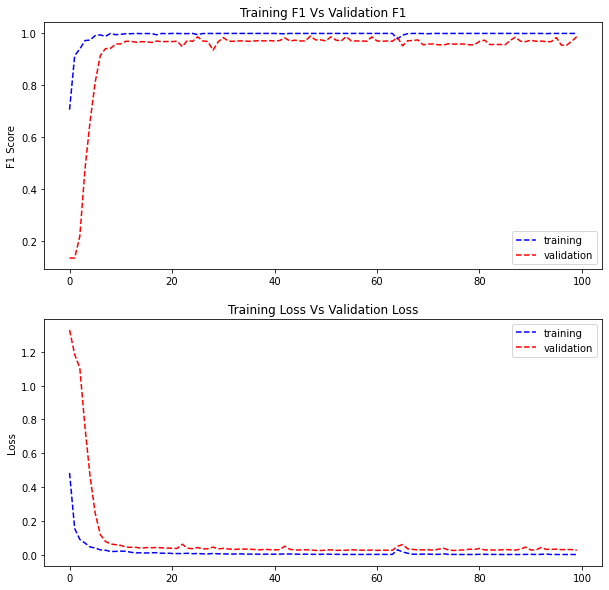

In [89]:
plot_accuracy_loss(model_leNet_SGD_shape, history_leNet_SGD_shape) 

In [71]:
model_leNet_SGD_shape.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_26 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_27 (Activation)   (None, 11, 11, 32)      

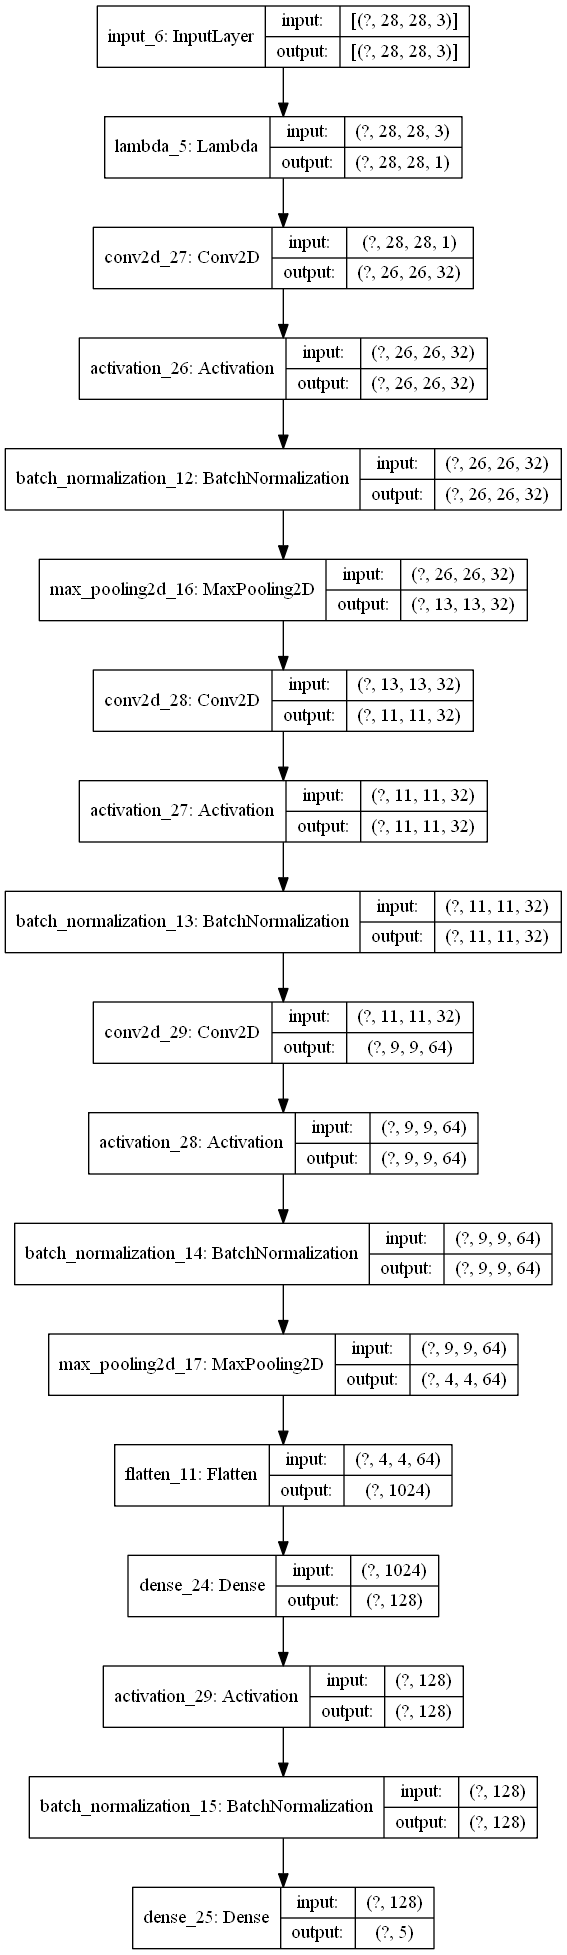

In [72]:
tf.keras.utils.plot_model(model_leNet_SGD_shape, show_shapes=True)

#### Traffic Sign Shapes

In [73]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator_shape = test_datagen.flow_from_dataframe(
        dataframe=test_data_shape, # load in traffic shape data
        directory='./',
        x_col="image_path",
        shuffle=False,
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 740 validated image filenames belonging to 5 classes.


In [74]:
model_nn_shape.evaluate(test_generator_shape) # evaluate model performance on test data

740/740 [==============================] - 1s 1ms/step - loss: 0.1381 - f1_score: 0.9591 - auc: 0.9851


[0.13811631500720978, 0.9591206312179565, 0.9851309657096863]

In [75]:
model_nn_2_shape.evaluate(test_generator_shape)

740/740 [==============================] - 1s 1ms/step - loss: 0.0993 - f1_score: 0.9632 - auc: 0.9852


[0.09928911924362183, 0.9632282257080078, 0.9851561784744263]

In [76]:
model_VGG_1_shape.evaluate(test_generator_shape)

740/740 [==============================] - 1s 2ms/step - loss: 0.1370 - f1_score: 0.9645 - auc: 0.9874


[0.1369830220937729, 0.9644569158554077, 0.9873889088630676]

In [77]:
model_leNet_1_shape.evaluate(test_generator_shape)

740/740 [==============================] - 1s 1ms/step - loss: 0.0825 - f1_score: 0.9767 - auc: 0.9931


[0.08251461386680603, 0.9766716957092285, 0.9930945038795471]

In [78]:
model_leNet_2_shape.evaluate(test_generator_shape)

740/740 [==============================] - 1s 1ms/step - loss: 0.0204 - f1_score: 0.9819 - auc: 0.9977


[0.020410872995853424, 0.9819308519363403, 0.9977338910102844]

In [90]:
model_leNet_SGD_shape.evaluate(test_generator_shape)

740/740 [==============================] - 1s 1ms/step - loss: 0.0373 - f1_score: 0.9779 - auc: 0.9973


[0.03732087090611458, 0.977935791015625, 0.9973244667053223]

#### Prediction for Traffic Sign Type 

Classification Report
                  precision    recall  f1-score   support

      rightofway       1.00      0.98      0.99        55
            stop       0.98      1.00      0.99        42
         bicycle       0.96      1.00      0.98        22
  limitedtraffic       1.00      1.00      1.00        44
         noentry       1.00      0.93      0.97        30
       noparking       0.86      1.00      0.92        18
      roundabout       1.00      0.99      0.99        68
           speed       1.00      0.98      0.99        46
trafficdirective       1.00      1.00      1.00        49
 traveldirection       1.00      0.99      0.99        69
        continue       1.00      1.00      1.00        17
        crossing       1.00      1.00      1.00        58
         laneend       1.00      1.00      1.00         9
         parking       0.97      1.00      0.99        39
         giveway       1.00      1.00      1.00        28
         warning       1.00      1.00      1.00  

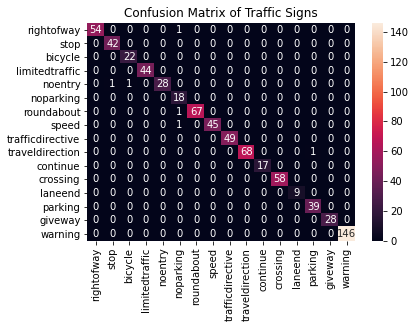

In [80]:
batch_size = 1 
Y_pred = model_leNet_2.predict(test_generator, 740 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1) # get the argmax of the values

cm = confusion_matrix(test_generator.classes, y_pred) # plot out confusion matrix to see how many are correctly and wrongly identified
labels = ['rightofway', 'stop', 'bicycle', 'limitedtraffic', 'noentry', 'noparking', 
     'roundabout', 'speed', 'trafficdirective', 'traveldirection', 'continue', 'crossing', 
     'laneend', 'parking', 'giveway', 'warning'] # list out target labels for traffic sign types
ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
ax.set_title('Confusion Matrix of Traffic Signs')

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=labels)) # plot out classification report to see overall metrics and performance on test set

#### Prediction for Traffic Sign Shape

Classification Report
              precision    recall  f1-score   support

     diamond       1.00      0.97      0.99        69
         hex       1.00      0.89      0.94         9
       round       0.99      1.00      1.00       329
      square       1.00      0.99      0.99       143
    triangle       0.99      1.00      0.99       190

    accuracy                           0.99       740
   macro avg       1.00      0.97      0.98       740
weighted avg       0.99      0.99      0.99       740



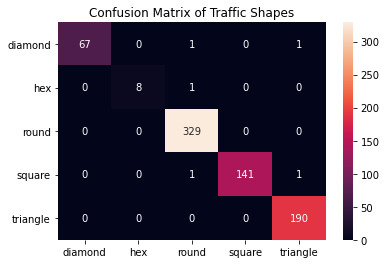

In [81]:
batch_size = 1
Y_pred = model_leNet_2_shape.predict(test_generator_shape, 740 // batch_size+1) # predict on generator object
y_pred = np.argmax(Y_pred, axis=1) # get the argmax of the values

cm = confusion_matrix(test_generator_shape.classes, y_pred)
labels = ['diamond', 'hex', 'round', 'square', 'triangle']  # list out target labels for traffic shape types
ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)  # plot out confusion matrix to see how many are correctly and wrongly identified
ax.set_title('Confusion Matrix of Traffic Shapes')

print('Classification Report')
print(classification_report(test_generator_shape.classes, y_pred, target_names=labels))  # plot out classification report to see overall metrics and performance on test set

### Independant Evaluation

#### Prepare images collected

In [82]:
files = zf.ZipFile("test_image.zip") # extract images from data we collected(real world data)
files.extractall()
files.close()

for dirname, _, filenames in os.walk('./test_image'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./test_image\diamond\rightofway\00094.png
./test_image\diamond\rightofway\05275.png
./test_image\diamond\rightofway\05276.png
./test_image\diamond\rightofway\05587.png
./test_image\diamond\rightofway\05595.png
./test_image\diamond\rightofway\05679.png
./test_image\diamond\rightofway\05702.png
./test_image\diamond\rightofway\05836.png
./test_image\diamond\rightofway\10601.png
./test_image\diamond\rightofway\10636.png
./test_image\diamond\rightofway\10718.png
./test_image\hex\stop\00111.png
./test_image\hex\stop\00224.png
./test_image\hex\stop\00251.png
./test_image\hex\stop\00417.png
./test_image\hex\stop\05232.png
./test_image\hex\stop\05388.png
./test_image\hex\stop\06171.png
./test_image\hex\stop\06203.png
./test_image\hex\stop\06796.png
./test_image\hex\stop\07180.png
./test_image\hex\stop\10101.png
./test_image\round\limitedtraffic\04401.png
./test_image\round\limitedtraffic\04777.png
./test_image\round\limitedtraffic\04863.png
./test_image\round\limitedtraffic\04971.png
./test_ima

In [83]:
for filename in glob.glob('./test_image/**/*.png', recursive=True):
    print(filename.split(".")[-2])
    img=cv2.imread(filename) # read the image files
    rl=cv2.resize(img, (28,28)) # resize them to the size we want , the sizes vary 
    gray_image = cv2.cvtColor(rl, cv2.COLOR_BGR2GRAY) # change the images to grayscale 
    cv2.imwrite(f'{filename}', gray_image) # write back this files to our directory

/test_image\diamond\rightofway\00094
/test_image\diamond\rightofway\05275
/test_image\diamond\rightofway\05276
/test_image\diamond\rightofway\05587
/test_image\diamond\rightofway\05595
/test_image\diamond\rightofway\05679
/test_image\diamond\rightofway\05702
/test_image\diamond\rightofway\05836
/test_image\diamond\rightofway\10601
/test_image\diamond\rightofway\10636
/test_image\diamond\rightofway\10718
/test_image\hex\stop\00111
/test_image\hex\stop\00224
/test_image\hex\stop\00251
/test_image\hex\stop\00417
/test_image\hex\stop\05232
/test_image\hex\stop\05388
/test_image\hex\stop\06171
/test_image\hex\stop\06203
/test_image\hex\stop\06796
/test_image\hex\stop\07180
/test_image\hex\stop\10101
/test_image\round\limitedtraffic\04401
/test_image\round\limitedtraffic\04777
/test_image\round\limitedtraffic\04863
/test_image\round\limitedtraffic\04971
/test_image\round\limitedtraffic\07350
/test_image\round\limitedtraffic\07462
/test_image\round\limitedtraffic\09913
/test_image\round\noent

#### Predict based on Collected Traffic Sign Types

In [84]:
image_list = [] # list to store images and labels
for filepath in glob.glob('./test_image/**/*.png', recursive=True): 
    filename = filepath.split("/")[-1]
    labels = filepath.split("\\")[-2] # split and extract information
    image_list.append((filepath, labels))
    
data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])
d = {'giveway':3, 'limitedtraffic':5, 'noentry':6, 'rightofway':9, 'roundabout':10, 'speed':11, 
     'stop':12, 'trafficdirective':13, 'traveldirection':14, 'warning': 15}

data['labels_num'] = data['label'].map(d, na_action='ignore')
new_data_types = data.loc[:,'image_path':'labels_num']

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last') # images should have shape (height, width, channels)

batch_size = 1

new_type_generator = test_datagen.flow_from_dataframe(
        dataframe=new_data_types,# load in from dataframe on traffic sign types
        directory='./',
        shuffle=False,
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 118 validated image filenames belonging to 10 classes.


In [85]:
batch_size = 1
Y_pred = model_leNet_2.predict(new_type_generator, 118 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(new_data_types['labels_num'], y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           3       1.00      1.00      1.00        12
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         4
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.92      1.00      0.96        11
          10       0.71      0.83      0.77         6
          11       0.93      1.00      0.96        13
          12       1.00      0.91      0.95        11
          13       1.00      0.87      0.93        15
          14       1.00      0.27      0.42        15
          15       0.96      1.00      0.98        24

    accuracy                           0.87       118
   macro avg       0.68      0.63      0.64       118
weighted avg       0.96      0.87      0.89       118



C:\Users\DY\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DY\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DY\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Predict based on Collected Traffic Shape Types

In [86]:
image_list = [] # list to store images and labels
for filepath in glob.glob('./test_image/**/*.png', recursive=True): 
    filename = filepath.split("/")[-1] # split and extract information
    labels = filepath.split("\\")[-3]
    image_list.append((filepath, labels))
    
data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])
d = {'diamond': 0, 'hex': 1, 'round': 2, 'triangle': 4}

data['labels_num'] = data['label'].map(d, na_action='ignore')
new_data_shape = data.loc[:,'image_path':'labels_num']

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

new_shape_generator = test_datagen.flow_from_dataframe(
        dataframe=new_data_shape, # load in from dataframe on traffic shape types
        directory='./',
        shuffle=False,
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 118 validated image filenames belonging to 4 classes.


In [87]:
batch_size = 1
Y_pred = model_leNet_2_shape.predict(new_shape_generator, 118 // batch_size+1) # predict on traffic shape generator
y_pred = np.argmax(Y_pred, axis=1) # take the max value of target function
print('Classification Report')
print(classification_report(new_data_shape['labels_num'], y_pred)) # produce classification report to see performance on this dataset

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.73      0.84        11
           2       0.95      0.93      0.94        60
           3       0.00      0.00      0.00         0
           4       0.92      1.00      0.96        36

    accuracy                           0.94       118
   macro avg       0.77      0.73      0.75       118
weighted avg       0.95      0.94      0.94       118



C:\Users\DY\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DY\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DY\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
